<H1>Clustering Notebook</h1>

This notebook includes the whole process of agglomerative heirarhcical clustering including all visualizations in the presentation. In this notebook is scraping and downloading the data, cleaning it, explaining how clustering works, and picking hyperparameters.

In [1]:
! pip3 install yfinance -q
! pip3 install numpy -q
! pip3 install seaborn -q
! pip install pandas-datareader -q
! pip install networkx -q
! pip install --upgrade nbformat -q
! pip install sklearn -q
! pip install scipy -q

In [2]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from datetime import datetime
''
# this workaround let's us override pandas_datareader with yfinance,
# although we can also use yfinance directly
import yfinance as yf
import pandas_datareader.data as web; yf.pdr_override()
import networkx as nx
import plotly.graph_objects as go
from matplotlib import cm
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster

<h3>Web Scraping (given)</h3>
scraping from wikipedia and yahoo finance to get companies from S&P 500


our time series is from the past year 2022-2023

In [3]:
start_date = '2022-01-01'
end_date  = '2022-12-31'

data_dir = '/Users/sofia/Onedrive/Documents/Github/BTT-JPMC-1'
dates = '_{}--{}'.format(start_date, end_date)
dates

'_2022-01-01--2022-12-31'

so we're getting the symbols from wikipedia

In [4]:
data    = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S%26P_500_component_stocks')
table_symbol   = data[0]
symbols = list(table_symbol.Symbol.values) #ticker symbols
os.makedirs(data_dir, exist_ok=True)

for each ticker symbol in our list we're going to get the closing price data from 01-01-2022 to 12-31-2022
make that into a dataframe df and store those in our directory

In [5]:
%%capture
symbols = sorted(symbols)
print("Downloading {} files".format(len(symbols)))
for i, symbol in enumerate(symbols):
    try:
        df = web.get_data_yahoo(symbol, start_date, end_date,)
        # df = web.DataReader(symbol,'yahoo', start_date, end_date)
        df = df[['Adj Close']]
        df.to_csv(os.path.join(data_dir, "{}.csv".format(symbol)))
    except KeyError:
      print("Error for {}".format(symbol))
      pass
print("Stored {} files".format(i+1))

<h2>Pre-processing the data</h2>
Now we have 500 csv files and we want to make one big one, indexed with all dates acorss 2022

In [6]:
index = pd.date_range(start=start_date, end=end_date, freq='D')     # initialize an empty DateTime Index and so each index is a date over the year
df_price = pd.DataFrame(index=index, columns=symbols)               # initialize empty dataframes

for symbol in symbols:
    symbol_df = pd.read_csv(os.path.join(data_dir, symbol+".csv")).set_index('Date')
    symbol_df.index = pd.to_datetime(symbol_df.index)
    df_price[symbol] = symbol_df['Adj Close']


now we;re going to remove any rows (days) where the stock price is nan, these would be like holidays or weekends

In [7]:
# Let's drop the dates where all the stocks are NaNs, ie., weekends/holidays where no trading occured
df_price.dropna(how='all', inplace=True)
df_price.dropna(inplace=True, axis=1)
True in pd.isna(df_price)

False

now we're going to find the price percentage change from day to day with the closing price. This is called the daily returns. we're using daily returns because if we use the raw price data our results will just clump all the big companies (with high stock prices) together, what we're looking for is to see which companies move similarly in the market, not ones that are similalrly priced

In [8]:
df_price_pct = df_price.pct_change()[1:]
df_price_pct.to_csv(os.path.join(data_dir, "prices_pct.csv"), index_label='date')
df_price_pct = df_price.pct_change().dropna(how='all')
df_price_pct.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2022-01-04,-0.033806,0.014400,-0.012692,-0.001920,-0.010887,-0.023518,0.013019,-0.007146,-0.018374,-0.009032,...,-0.003190,0.006329,0.037614,0.005098,0.010608,0.005347,0.010145,0.006337,0.028487,-0.038072
2022-01-05,-0.017131,-0.017876,-0.026600,0.005253,-0.050059,-0.004493,-0.011744,-0.017611,-0.071426,-0.015437,...,-0.037033,0.009799,0.012437,-0.016090,-0.013629,-0.012676,-0.003296,-0.050068,0.002270,-0.038024
2022-01-06,0.003499,-0.005889,-0.016693,-0.004710,-0.015408,-0.000148,0.005830,-0.048290,-0.000603,0.003182,...,0.004629,-0.007822,0.023520,-0.000711,-0.001373,0.010330,-0.008307,-0.005410,0.041075,0.003971
2022-01-07,-0.026623,0.038234,0.000988,-0.002588,0.039437,0.003108,0.004681,-0.019180,-0.006652,-0.026241,...,-0.001063,0.008759,0.008197,0.003202,-0.007992,-0.011466,-0.006050,-0.043771,0.016681,-0.029114
2022-01-10,0.000069,-0.025415,0.000116,0.011195,-0.032159,-0.002213,0.021078,0.006069,0.029626,0.009239,...,-0.028149,0.010998,-0.005952,-0.016844,-0.010136,-0.013964,-0.009754,0.008571,-0.007562,0.007153


<h2>Outlier detour</h2>
This is not explored in our presentation but if we had more time we would look into the affect outliers have on our data. There seems to be some days and companies where the returns are abnormally high or low

below shows which companies are outliers across the whole year

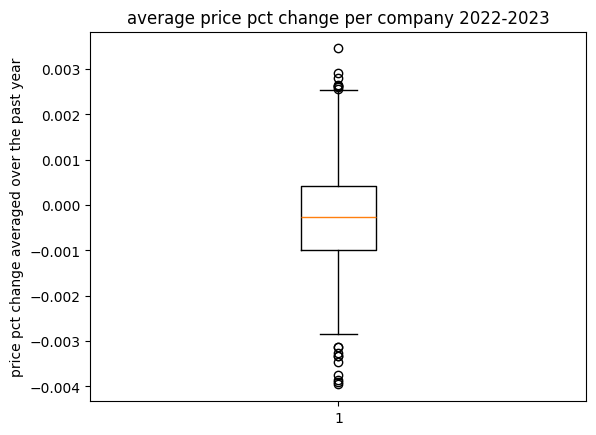

count    496.000000
mean      -0.000281
std        0.001162
min       -0.003956
25%       -0.000993
50%       -0.000271
75%        0.000421
max        0.003455
dtype: float64

In [9]:
df_price_plotting = df_price_pct
df_2 = df_price_plotting.mean(axis=0)
avg_per_company = list(df_2.values)
plt.boxplot(avg_per_company)
plt.title('average price pct change per company 2022-2023')
plt.ylabel('price pct change averaged over the past year')
plt.show()
df_2.describe()

below shows which days in the time series are outliers

C:\Users\sofia\AppData\Local\Temp\ipykernel_8288\2829923260.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_price_plotting['average'] = df_price_plotting.mean(axis=1)


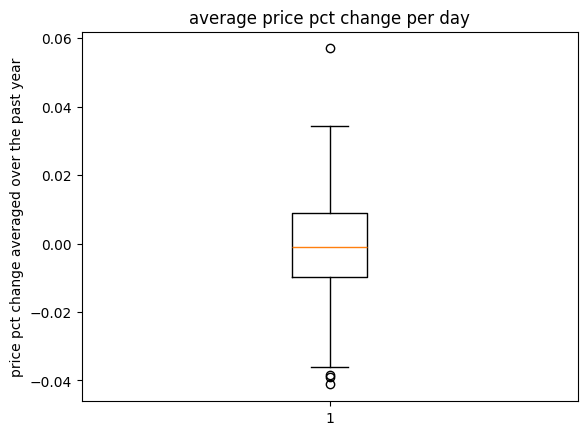

In [10]:
df_price_plotting['average'] = df_price_plotting.mean(axis=1)
#average across all companies per day
# Creating plot
plt.boxplot(df_price_plotting['average'])
# show plot
plt.title('average price pct change per day')
plt.ylabel('price pct change averaged over the past year')
plt.show()

now this is an overall graph showing how every company on the index did

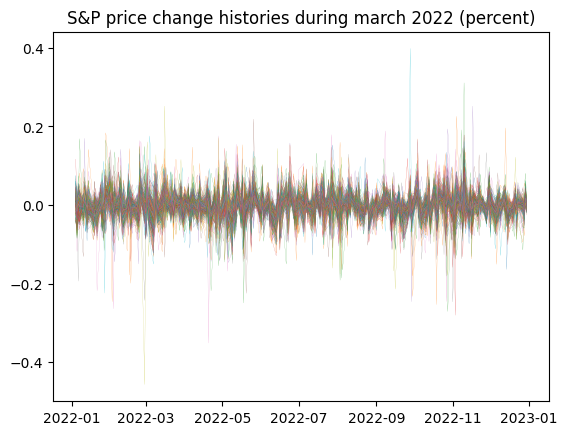

In [11]:
plt.title('S&P price change histories during march 2022 (percent)')
plt.plot(df_price_pct, linewidth=0.10)
plt.show()

now we're going to take those returns and make the dataframe into a correlation matrix. showing how the daily returns of each company is related to the other 500, we want companies that move similarly in the market to be highly correlated

In [12]:
price_corr = df_price_pct.corr()
price_corr.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,average
A,1.000000,0.407709,0.655079,0.326509,0.508650,0.694500,0.387889,0.716137,0.646866,0.659651,...,0.377577,0.244666,0.467659,0.644946,0.571664,0.549947,0.608282,0.486459,0.717033,0.765326
AAL,0.407709,1.000000,0.578066,0.150789,0.656190,0.457502,0.443662,0.543218,0.471284,0.601553,...,0.211978,0.117557,0.335173,0.518664,0.536259,0.494229,0.513814,0.554393,0.392053,0.689751
AAPL,0.655079,0.578066,1.000000,0.237847,0.614346,0.626045,0.409057,0.793634,0.712878,0.757031,...,0.435888,0.272653,0.446410,0.622753,0.577939,0.563028,0.714866,0.562129,0.669387,0.818158
ABBV,0.326509,0.150789,0.237847,1.000000,0.064071,0.459730,0.231744,0.339734,0.183755,0.293731,...,0.374312,0.180720,0.305447,0.274008,0.250046,0.322012,0.177527,0.264412,0.400357,0.386484
ABNB,0.508650,0.656190,0.614346,0.064071,1.000000,0.453697,0.279895,0.609635,0.553967,0.624117,...,0.114636,0.262851,0.432287,0.512740,0.547555,0.495449,0.566134,0.504051,0.490283,0.693499


Text(0.5, 1.0, 'Correlation heatmap for Price Changes')

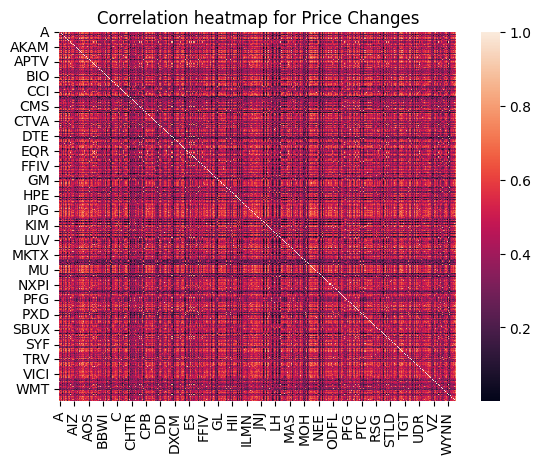

In [13]:
sns.heatmap(abs(price_corr)).set_title("Correlation heatmap for Price Changes")

<h1>Clustering</h1>
heirarhcical agglomerative clustering is a bottom up unsupervised learning approach that creates clusters and visualizes them in a tree-like structure (called dendrogram) this method is useful if you don't know the number of clusters you want beforehand

<h3>Clustering Data</h3>
1-abs(df_price_pct.corr().values)

is a lot to unpack lol. df_price_pct.corr() is the correlation matrix of daily returns for all 500 companies related to each other. We then find the absolute value of those numbers because a strong negative correlation is just as important as a strong positive correlation. We're doing 1- all of that because heirarichical clustering is typically made for distance matrices not similarity matrices. heirarhcial clustering will group together two nodes if they're distance is lower, because that means the two nodes are closer together, to acheive this with similarity we have to take the inverse to highly correlated companies will have a lower number, meaning they are "closer" together

our clustering is based off of the below dissimilarity matrix

In [14]:
dissimilarity = 1- abs(df_price_pct.corr().values)

#diff types of linkage determine how the clusters are merged 
# single - merge clusters closest together , 
# complete - merge clusters furthest
#ward linkage attempts to minimize variance within clusters after being merged
#single linkage maximized the cophenetic correlation the others were around .34 and .38

using our dissimilarity matrix we create a linkage matrix (Z)
The linkage matrix is what clusters our data points together. Each row in the matrix describes a merge of two clusters, 4 values in each row. the first two values are the indeces of the two datapoints merged, the third value is the disimilarity value they were merged at and the 4th value is how many clusters were merged (always 2)

linkage method is how you calculate which companies are "closer" together in the dissimilariry matrix. Each time a merge is performed the dissimilarity matrix is updated with new values from the merged cluster to all the remaining data points.
<b>Single linkage</b> - recalculates the dissimiarlity (or distance) matrix using the minimum distance between clusters or points
<b>complete linkage</b> - recalculates the distance matrix using the maximum distance between clusters or points
<b>Average linkage</b> - recalculates the distance matrix using the average distance between clusters
<b>Ward linkage</b> - recalculates distance based on how merging those points will increase the sum of squares. The point is to create clusters that minimize variance and are very compact

In [15]:
Z = linkage(squareform(dissimilarity), method="ward")


once the linkage matrix is made (Z) you can visualize the results with a dendrogram

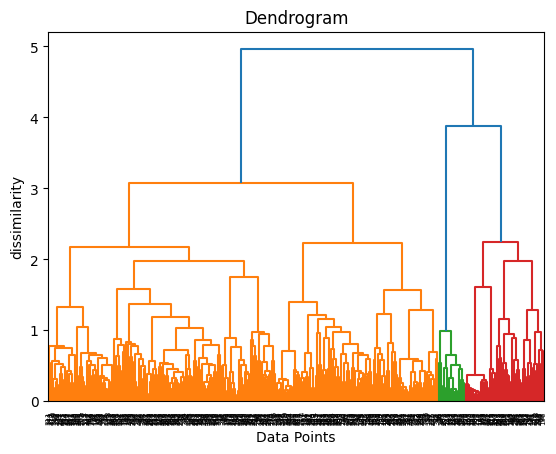

In [16]:
dendrogram = sch.dendrogram(Z)
plt.xlabel('Data Points')
plt.ylabel('dissimilarity')
plt.title('Dendrogram')
plt.show()

this dendrogram shows you where all 500 points are merged together at (xaxis is all companies) but to actually get the clusters you need to choose a threshold to cut the dendrogram at. If you cut the above dendrogram at 2.9 dissimialrity there would be 4 clusters, if you cut at 4.5 there will be 2 clusters etc etc

In [17]:
labels = fcluster(Z, 2.9, criterion='distance')
num_clusters = len(set(labels))


unique_labels = np.unique(labels)
cluster_sizes = [np.sum(labels == label) for label in unique_labels]

print('there are ', num_clusters, ' clustres and these are the sizes of each', cluster_sizes)


there are  4  clustres and these are the sizes of each [228, 163, 27, 79]


<h2>There are two hyperparameters: number of clusters and linkage</h2>

to find the linkage we looked for linkage methods that would provide a balanced number of clusters so not [499, 1, 1] but maybe [300, 100, 100].
Based off of theory and domain knowledge we can assume the ward linkage would be best

so at various thresholds (number of clusters), I used different linkage methods and found the distributions of nodes the clusters. In theory if the standard deviation of these spreads is smaller then that means the sizes of the clusters are less extreme and more balanced.

finding balanced clusters is very important because if you have [498,1,1] or [1,1,1,2,1,1,1,1,...1,1,1,1] then its the same as not clustering at all

these thresholds are the thresholds for each linkage method that at which you can get 2-15, 20, & 25 clusters from. All of the linkage methods calculate distance differently si theyre all on different scales. this is why i needed threshold numbers for each

In [18]:
thresholds_ward = [4.0,3.5, 3.0, 2.24,2.2, 2.1,1.981,1.980, 1.7,1.35,1.2, 1.04] #1.35 is threshold for 15 1.2 is 20 clusters
thresholds_comp = [.999,.995,.990, .965,.96,.94,.91,.87,.84,.80,.76, .721 ] #.80 is threshold for 15, 0.76 is 20
thresholds_single = [.55,.54, .53, .51,.50, .49,.486,.485,.480,.471,.4475,.43 ] #.471 is threshold for 15, 0.4475 for 20 clusters
thresholds_average = [.80,.79,.73,.71,.70, .69,.675,.66,.659 ,.6425,.614,.6] #.6425 is theshold for 15, 0.614 is for 20 clsuters
ward_std = []
comp_std = []
aver_std = []
sing_std = []
num_cluster_plot = []

this large for loop finds out the distribution of clusters for each linkage method at varying thresholds (see above cell)
displays result in bar plot, we want to minimize the standard deviation. low standard deviation means the distributions of the cluster sizes are close together

For ward linkage there are 2 clusters and these are the sizes of each [391, 106]  the standard deviation is  142.5
For complete linkage there are 2 clusters and these are the sizes of each [408, 89]  the standard deivation is  159.5
For single linkage there are 2 clusters and these are the sizes of each [496, 1]  the standard deivation is  247.5


For ward linkage there are 3 clusters and these are the sizes of each [391, 27, 79]  the standard deviation is  160.7427205885922
For complete linkage there are 3 clusters and these are the sizes of each [408, 29, 60]  the standard deivation is  171.82225958498185
For single linkage there are 3 clusters and these are the sizes of each [495, 1, 1]  the standard deivation is  232.87383327076967


For ward linkage there are 4 clusters and these are the sizes of each [228, 163, 27, 79]  the standard deviation is  77.08882863294785
For complete linkage there are 4 clusters and these are the sizes of each [265, 143, 29, 60]  the standard deivation 

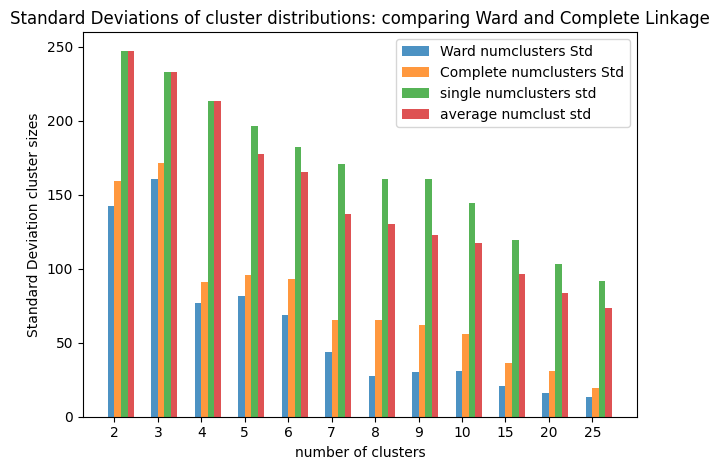

In [19]:


for i, j,k,l in zip(thresholds_ward, thresholds_comp, thresholds_single, thresholds_average):
    Z_ward = linkage(squareform(dissimilarity), method="ward", optimal_ordering=True)
    Z_comp = linkage(squareform(dissimilarity), method="complete", optimal_ordering=True)
    Z_sing = linkage(squareform(dissimilarity), method="single", optimal_ordering=True)
    Z_aver = linkage(squareform(dissimilarity), method="average", optimal_ordering=True)
    


    labels_ward = fcluster(Z_ward, i, criterion="distance")
    labels_comp = fcluster(Z_comp, j, criterion="distance")
    labels_sing = fcluster(Z_sing, k, criterion="distance")
    labels_aver = fcluster(Z_aver, l, criterion="distance")

    unique_labels_ward = np.unique(labels_ward)
    cluster_sizes_ward = [np.sum(labels_ward == label) for label in unique_labels_ward]

    unique_labels_comp = np.unique(labels_comp)
    cluster_sizes_comp = [np.sum(labels_comp == label) for label in unique_labels_comp]

    unique_labels_sing = np.unique(labels_sing)
    cluster_sizes_sing = [np.sum(labels_sing == label) for label in unique_labels_sing]

    unique_labels_aver = np.unique(labels_aver)
    cluster_sizes_aver = [np.sum(labels_aver == label) for label in unique_labels_aver]


    # Calculate the standard deviation for each method you want the lowest standard devation to make the clusters balanced
    ward_std_dev = np.std(cluster_sizes_ward)
    comp_std_dev = np.std(cluster_sizes_comp)
    ward_std.append(ward_std_dev)
    comp_std.append(comp_std_dev)
    num_cluster_plot.append(max(labels_ward))

    sing_std_dev = np.std(cluster_sizes_sing)
    aver_std_dev = np.std(cluster_sizes_aver)
    sing_std.append(sing_std_dev)
    aver_std.append(aver_std_dev)
    

    print('For ward linkage there are', max(labels_ward), 'clusters and these are the sizes of each', cluster_sizes_ward, ' the standard deviation is ', ward_std_dev)
    print('For complete linkage there are', max(labels_comp), 'clusters and these are the sizes of each', cluster_sizes_comp, ' the standard deivation is ', comp_std_dev)
    print('For single linkage there are', max(labels_sing), 'clusters and these are the sizes of each', cluster_sizes_sing, ' the standard deivation is ', sing_std_dev)
    print('\n')
    
bar_width = 0.15
opacity = 0.8
index = np.arange(len(thresholds_ward))

plt.bar(index, ward_std, bar_width, label='Ward numclusters Std', alpha=opacity)
plt.bar(index + bar_width, comp_std, bar_width, label='Complete numclusters Std', alpha=opacity)
plt.bar(index+bar_width+bar_width,sing_std, bar_width, label = "single numclusters std", alpha = opacity)
plt.bar(index+bar_width+bar_width+bar_width, aver_std, bar_width, label="average numclust std", alpha = opacity)



plt.xlabel('number of clusters')
plt.ylabel('Standard Deviation cluster sizes')
plt.title('Standard Deviations of cluster distributions: comparing Ward and Complete Linkage')
plt.xticks(index + bar_width / 2, [str(clust) for clust in num_cluster_plot])
plt.legend()

plt.tight_layout()
plt.show()



the above bar plot shows that no matter how many clusters are chosen, ward always gives the most balanced distributino of clsuter sizes

so we'll use ward linkage to make our linkage matrix

<h2>We have linkage, lets choose a threshold/h2>

we're going to use the metric silhouette score to find the best threshold to cut our dendrogram at. I'm going to plot it and find where silhouette score is the highest

silhouette score is a metric that values compact and separated clusters so small clusters that are far apart. we want a high silhouette score

In [20]:
thresholds = np.arange(0.1, 4.5, 0.1)


#im going to store the results of this for loop into a dataframe so i can compare everything better
columns = ['threshold','Silhouette', 'num clusters']
price_corr_eval = pd.DataFrame(columns=columns)
        
for t in thresholds:
        Z = linkage(squareform(dissimilarity), method = "ward")
        labels = fcluster(Z, t, criterion='distance')
        silhouette_avg = silhouette_score(dissimilarity, labels, metric='precomputed')
        #silhouette_scores.append(silhouette_avg)

        c, _ = cophenet(Z, squareform(dissimilarity))
        #cophenet_correlations.append(c)
        ch = calinski_harabasz_score(dissimilarity, labels)
        num_clusters = max(labels)
        new_row = [t, silhouette_avg, num_clusters]
        price_corr_eval.loc[len(price_corr_eval)] = new_row
        #print(f"Silhouette Score for threshold {t}: {silhouette_avg} and cophenet corr for link method {l}: {c}")
price_corr_eval.head()

,threshold,Silhouette,num clusters
0,0.1,0.051817,464.0
1,0.2,0.157939,356.0
2,0.3,0.191630,266.0
3,0.4,0.219113,176.0
4,0.5,0.201491,123.0


Text(0.5, 1.0, 'num clust vs silhouette score for ward linkage')

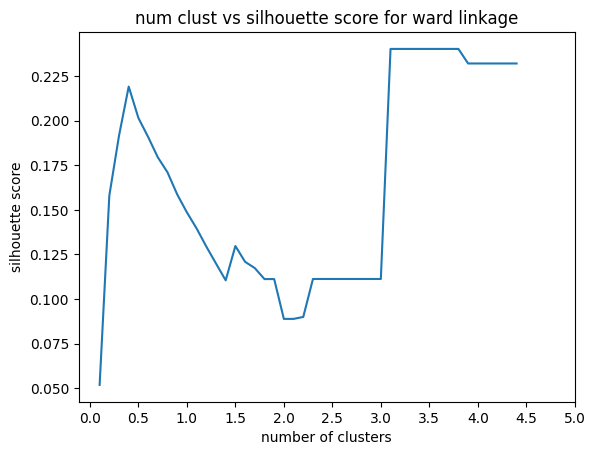

In [21]:
plt.plot(price_corr_eval['threshold'], price_corr_eval['Silhouette'])
plt.xticks(np.arange(0, 5.5, 0.5))
# Add labels and title
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.title('num clust vs silhouette score for ward linkage')

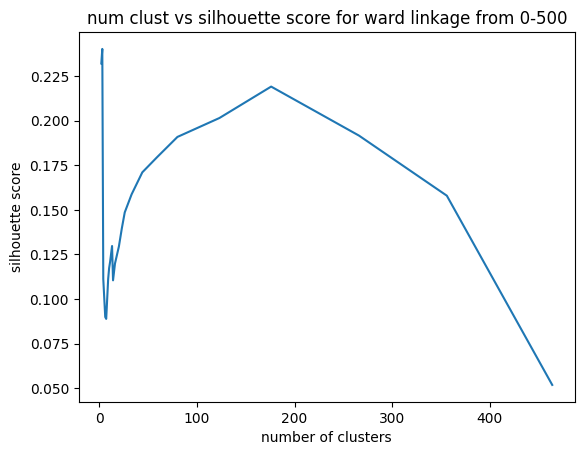

In [22]:
plt.plot(price_corr_eval['num clusters'], price_corr_eval['Silhouette'])

# Add labels and title
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.title('num clust vs silhouette score for ward linkage from 0-500')
plt.show()